In [3]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_selection import chi2
import os
import gensim
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
from gensim.models import ldamodel, doc2vec, LsiModel 
import nltk
# nltk.download('punkt')
import string
import csv
import math
import statistics
import datetime
from nltk.corpus import stopwords
from nltk.util import ngrams
# nltk.download('stopwords')
from collections import OrderedDict, Counter, namedtuple
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.layouts import row, column
import random
import codecs, difflib, Levenshtein, distance
import rpy2
from datasketch import MinHash
import warnings
warnings.filterwarnings('ignore')
# nlp = spacy.load('en_core_web_lg')
# %load_ext rpy2.ipython


In [2]:
eg_unordered = pd.read_csv('ocr_test_magazine_arab_scribe_unordered.csv')
eg_ordered = pd.read_csv('ocr_test_magazine_arab_scribe_ordered.csv')

eg_ordered['contains_image'].fillna(value=False, inplace=True)

for index, row in eg_ordered.iterrows():
    if math.isnan(row['page_number']):
        pgn = row['base_file_name'].split('imagefile')[0][-3:]
        pgn = pgn.split('_')[0]
        eg_ordered.loc[index, 'page_number'] = int(pgn)

groupby_df = eg_ordered.groupby('page_number')['google_vision_text'].apply(' '.join).reset_index()
eg_ordered = eg_ordered.drop_duplicates(subset=['page_number'], keep='first')
eg_ordered = eg_ordered.drop(columns='google_vision_text')
final_df = pd.merge(eg_ordered, groupby_df, on='page_number', how='outer')
eg_ordered = final_df.drop(columns='id')

In [11]:
htrc_df = pd.read_csv('htrc_grouped.csv')

In [14]:
def custom_tokenize(text):
    if not text:
#       print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.word_tokenize(text)

def process_text(df, punc):

    final_doc = []
    pages = []
    for index, row in df.iterrows():
        page = []
        raw_text = row['lowercase']
        tokens = custom_tokenize(raw_text)
        for t in tokens:
            if punc:
                if t in string.punctuation:
                    pass
                elif t in stopwords.words('english'):
                    pass
                else:
                    final_doc.append(t.lower())
                    page.append(t.lower())
            else: 
                final_doc.append(t.lower())
        pages.append(' '.join(page))
    text = ' '.join(final_doc)
    return final_doc, text, pages

In [15]:
htrc_docs, htrc_text, htrc_pages = process_text(htrc_df, True)

In [16]:
len(htrc_pages)

592

In [4]:
order_list, order_text, order_pages = process_text(eg_ordered, True)
unorder_list, unorder_text, unorder_pages = process_text(eg_unordered, True)
all_documents = [order_text, unorder_text]

['the scribe the arab review 4th year vol vii no 5 – january 1964 monthly magazine published french english german italian spanish towards arab reconciliation the fifth year high dam', 'arab observer the non-aligned weekly', 'chou en-lai in the u.a.r the problem of transportation in africa monthly close-up reflection in trip life encounter people many strange place along many strange road ... every- thing accomplished ought ought us charles dickens 1812-1870 the arab summit 110,000 laureates honoured', "the scribe he arab review contents page editorial the political scene mr. chou-en-lai 's visit cairo re-affirmation peaceful coexistance co-operation fifth year high dam the course nile diverted next may ... ... on education day the u.a.r pays solemn tribute pioneers arab affairs towards arab reconciliation at international federation petrol- eum chemical workers the uar elected overwhelming majority vice-presidency a meaningful presence ... documents .. the economic scribe studies inve

['the scribe the arab review 4th year vol vii no 5 – january 1964 monthly magazine published french english german italian spanish towards arab reconciliation the fifth year high dam', 'arab observer the non-aligned weekly', 'chou en-lai in the u.a.r the problem of transportation in africa monthly close-up reflection in trip life encounter people many strange place along many strange road ... every- thing accomplished ought ought us charles dickens 1812-1870 the arab summit 110,000 laureates honoured', "the scribe the scribe cribe the arab review arab review monthly magazine published french english german italian spanish 38 ramses ave. cairo u.a.r tel 45405 editor chief dr. adel amer managing editor victor sahyoun editorial board fikri meleka dr. g.h sadek r. tagher – m. hakki editor english edition abeya nafrawy contents page editor german edition kawsar amer editors italian edition mussa badawi dr. m. a. bianco editor spanish edition dr. atteya heykal 16 editorial .. ... the politic

In [17]:
# counts = CountVectorizer(ngram_range=(1,5))
# counts_matrix = counts.fit_transform(order_pages)
# cos = cosine_similarity(counts_matrix[0:1], counts_matrix)
# print(cos[0][1])
# ocr_values.append(cos[0][1])
tokenize = lambda doc: doc.lower().split(" ")
counts = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenize, ngram_range=(1,1))
counts_matrix = counts.fit_transform(htrc_pages)
dtm = counts_matrix.toarray() 
dist = euclidean_distances(dtm)
cos = 1- cosine_similarity(dtm)
norms = np.sqrt(np.sum(dtm * dtm, axis=1, keepdims=True))
dtm_normed = dtm / norms
sim = np.dot(dtm_normed, dtm_normed.T)
sim[1, 3]

0.14312011202103248

In [18]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(cos)
xs, ys = pos[:, 0], pos[:, 1]

In [19]:
names = [str(row['page']) for index, row in htrc_df.iterrows()]

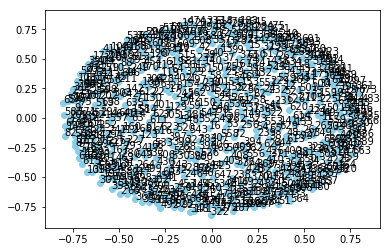

In [20]:
for x, y, name in zip(xs, ys, names):
   col = 'orange' if "imagefile" in name else 'skyblue'
   plt.scatter(x, y, c=col)
   plt.text(x, y, name)

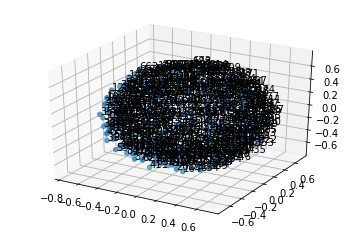

In [21]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(cos)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], names):
    ax.text(x, y, z, s)
plt.show()

In [22]:
from scipy.cluster.hierarchy import ward, dendrogram

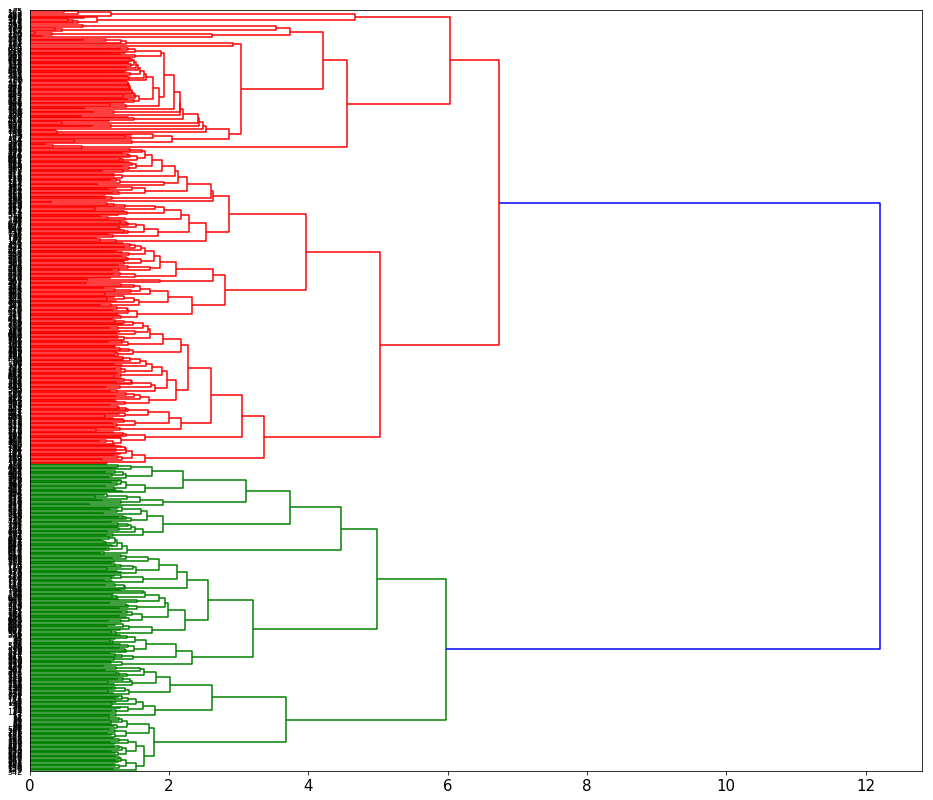

In [23]:
linkage_matrix = ward(cos)
plt.figure(figsize=(16,14))
dendrogram(linkage_matrix, orientation="right", labels=names)
# plt.tight_layout() 
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.savefig('t.png')

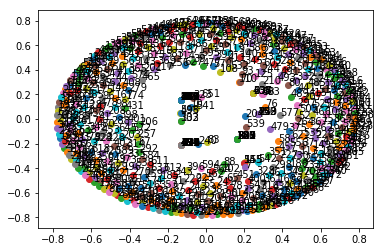

In [24]:
keyness, _ = chi2(counts_matrix, names)
selected = np.argsort(keyness)[::-1][0:50]
dtm_chi2 = dtm[:, selected]
dist = 1 - cosine_similarity(dtm_chi2)
mds = MDS(n_components=2, dissimilarity="precomputed")
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

for x, y, name in zip(xs, ys, names):
#    color = 'orange' if "Austen" in name else 'skyblue'
   plt.scatter(x, y)
   plt.text(x, y, name)
plt.show()

In [25]:
vocab = np.array(counts.get_feature_names())
ranking = np.argsort(keyness)[::-1]
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)
vocab[ranking][0:100]

array(['sport', '', '^umiere', 'soaring', 'laps', 'benaal', '60uda', '6cm',
       'tke', '60um', 'fatm', 'fathi', 'chronology', 'indiana', '75',
       'sculptured', 'watan', 'hygienic', 'summi', 'supplement', 'flie',
       'frame-work', 'devise', 'mawla', 'review', 'powerhouse',
       'posterior', 'mixers', 'bena', 'unanimity', 'barneses',
       'baseraltef', '£7', 'lit', '■5', 'r', 'birth-pangs', 'aerodrome',
       '^irr', 'manchester', 'jam.65', 'indiana^', 'nasr', 'newsreel',
       'spatial', 'surge', 'imiimiiimiimiimi', 'spring-board', 'treating',
       'agency', 'auk', 'bungalow-like', 'ike', 'ger', 'johnson—', 'a*',
       'clover', 'stamps', 'effigy', 'plagued', '-rica', 'aba', 'weekly',
       'chariot', 'giant', 'library', 'seaport', 'juajfc', 'kourta',
       'millenial', 'skyscrapers', 'panoramic', '``', 'performing',
       'talee', 'shagara', 'ya', 'bustles', 'lining', 'qrp',
       'publications', 'tom-tom', '864,500', '5,672,750', 'solid',
       'waltari', 'deed

In [33]:
from sklearn import decomposition
num_topics = 50
num_top_words = 20
clf = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = clf.fit_transform(dtm)

In [34]:
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
topic_words

[['minister',
  'said',
  'conference',
  '—',
  'meeting',
  'uar',
  '1964',
  'president',
  'el',
  'mr',
  'mr.',
  'announced',
  'communique',
  'held',
  'foreign',
  'added',
  'visit',
  'summit',
  'affairs',
  'agreement'],
 ['water',
  'metres',
  'irrigation',
  'nile',
  'river',
  'flood',
  'cubic',
  'waters',
  'million',
  'feddans',
  'land',
  'cultivated',
  'storage',
  'increase',
  'milliard',
  'floods',
  'completed',
  'crops',
  'perennial',
  'dam'],
 ['editor',
  'edition',
  'spanish',
  'italian',
  'english',
  'a.',
  'german',
  'm.',
  'r.',
  'bianco',
  'printed',
  'dr.',
  'editorial',
  'monthly',
  'amer',
  'hassan',
  '38',
  'french',
  'magazine',
  'h.'],
 ['bernard',
  'emile',
  'painter',
  'artist',
  'paintings',
  'gogh',
  'egypt',
  'van',
  '»',
  'painted',
  'art',
  '«',
  'father',
  '1893',
  'samos',
  'life',
  'little',
  'monks',
  '...',
  'pictorial'],
 ['countries',
  'development',
  'economic',
  'underdeveloped',


In [35]:
names = np.asarray(names)

In [36]:
doctopic_orig = doctopic.copy()
num_groups = len(set(names))
doctopic_grouped = np.zeros((num_groups, num_topics))
for i, name in enumerate(sorted(set(names))):
    doctopic_grouped[i, :] = np.mean(doctopic[names == name, :], axis=0)
doctopic = doctopic_grouped

In [37]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: minister said conference — meeting uar 1964 president el mr mr. announced communique held foreign
Topic 1: water metres irrigation nile river flood cubic waters million feddans land cultivated storage increase milliard
Topic 2: editor edition spanish italian english a. german m. r. bianco printed dr. editorial monthly amer
Topic 3: bernard emile painter artist paintings gogh egypt van » painted art « father 1893 samos
Topic 4: countries development economic underdeveloped social cf 1 2 africa developed p international increase developing technical
Topic 5: review arab 1964 march february supplement july — ger johnson— mo promotion unanimity implementation human
Topic 6: sq miles population country born president capital area party mainly elected education language french agriculture
Topic 7: efficient ticker up-to-minute -events briefing bulletin researches features researchers comtel rendered views issues men english
Topic 8: magazine agency published news middle east people 

In [38]:
names = sorted(set(names))
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(names[i], top_topics_str))

10: 27 12 10
100: 27 24 22
101: 27 18 48
102: 27 49 12
103: 27 42 33
104: 7 10 13
105: 33 40 7
106: 5 8 11
107: 45 24 13
108: 47 49 11
109: 2 5 11
11: 9 47 42
110: 2 5 30
111: 30 17 10
112: 30 39 6
113: 30 28 7
114: 30 28 17
115: 30 46 43
117: 30 40 35
118: 30 5 12
119: 30 11 33
12: 30 24 47
120: 30 45 5
121: 30 44 48
122: 30 21 16
123: 32 38 31
124: 32 38 4
125: 32 38 3
126: 38 32 34
127: 11 9 10
128: 11 18 5
129: 30 11 16
13: 11 21 30
130: 11 38 37
131: 12 11 48
132: 11 41 43
133: 11 43 12
134: 12 28 11
135: 12 28 30
136: 4 31 17
137: 31 45 4
138: 4 17 21
139: 11 30 8
14: 4 38 32
140: 4 28 9
141: 34 4 42
142: 34 5 49
143: 34 21 22
144: 34 9 10
146: 34 47 43
147: 41 9 46
148: 0 46 12
149: 5 11 45
15: 47 0 43
150: 0 20 35
151: 0 12 11
152: 11 0 12
153: 0 35 34
154: 12 0 11
155: 0 14 9
156: 10 21 9
157: 17 30 12
158: 17 16 18
159: 11 9 10
16: 17 16 30
160: 17 30 12
161: 11 39 16
162: 5 32 38
163: 25 7 12
164: 31 5 39
165: 39 5 10
166: 39 21 19
167: 39 12 8
168: 39 46 16
169: 11 12 0
17:

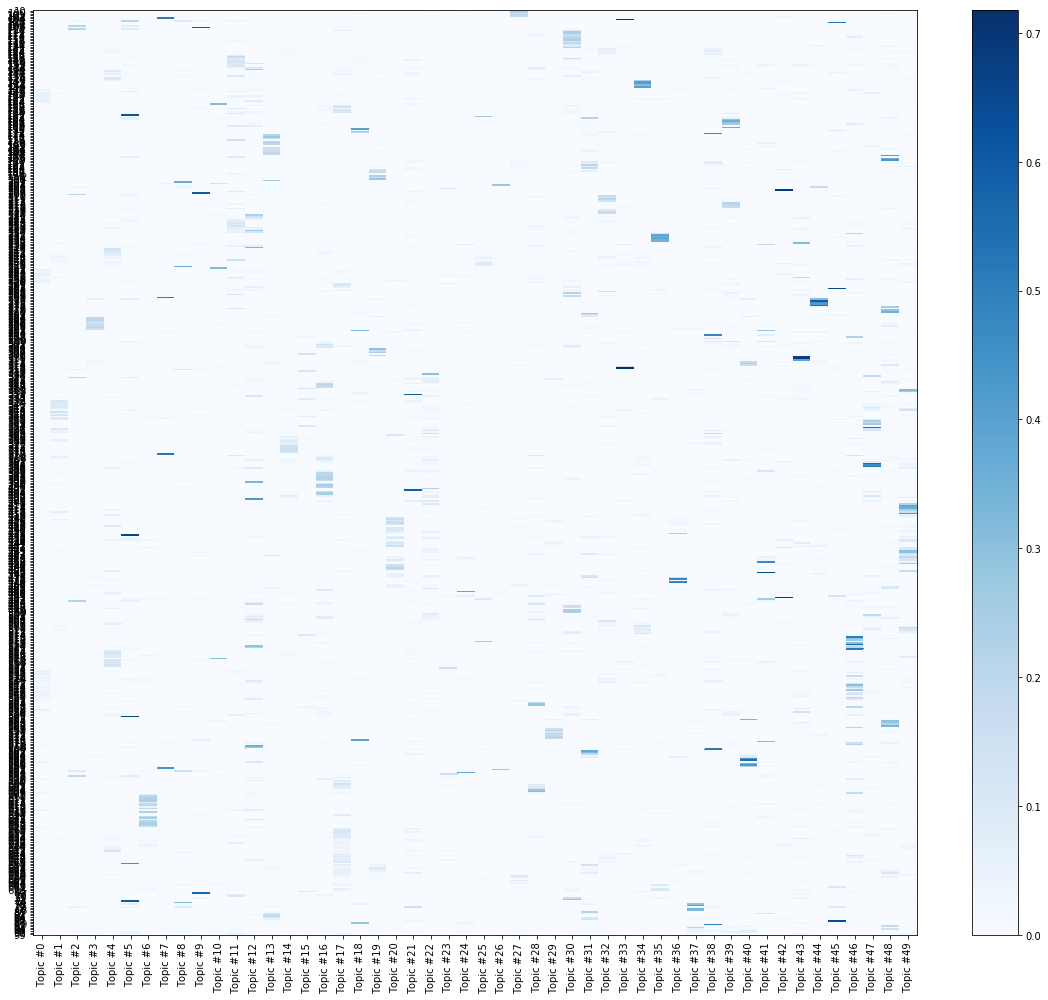

In [39]:
plt.figure(figsize=(16,14))
plt.pcolor(doctopic, norm=None, cmap='Blues')

plt.yticks(np.arange(doctopic.shape[0])+0.5, names);
N, K = doctopic.shape
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels)
# ax = plt.gca()
# ax.tick_params(axis='x', which='major', labelsize=15)
# ax.tick_params(axis='y', which='major', labelsize=8)
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Blues')
plt.tight_layout()
plt.show()